In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

import random

# Data prep before running

In [2]:
data = pd.read_csv('vegas_cuisine.csv')
data.shape

(3779, 422)

In [3]:
empty = ['AcceptsInsurance',
 'ByAppointmentOnly',
 'RestaurantsPriceRange2',
 'Music_background_music',
 'Music_karaoke',
 'Music_live',
 'Music_jukebox',
 'Ambience_romantic',
 'Ambience_intimate',
 'Ambience_classy',
 'Ambience_hipster',
 'Ambience_divey',
 'Ambience_touristy',
 'Ambience_trendy',
 'Ambience_upscale',
 'Ambience_casual',
 'RestaurantsGoodForGroups',
 'Open24Hours',
 'BYOBCorkage',
 'Corkage',
 'DietaryRestrictions_dairy-free',
 'BusinessAcceptsCreditCards',
 'BusinessParking_garage',
 'GoodForKids',
 'WheelchairAccessible',
 'BikeParking',
 'Alcohol',
 'HasTV',
 'NoiseLevel',
 'RestaurantsAttire',
 'Music_dj',
 'Music_no_music',
 'Music_video',
 'Caters',
 'WiFi',
 'RestaurantsReservations',
 'RestaurantsTakeOut',
 'HappyHour',
 'GoodForDancing',
 'RestaurantsTableService',
 'OutdoorSeating',
 'RestaurantsDelivery',
 'BestNights_monday',
 'BestNights_tuesday',
 'BestNights_friday',
 'BestNights_wednesday',
 'BestNights_thursday',
 'BestNights_sunday',
 'BestNights_saturday',
 'GoodForMeal_dessert',
 'GoodForMeal_latenight',
 'GoodForMeal_lunch',
 'GoodForMeal_dinner',
 'GoodForMeal_breakfast',
 'GoodForMeal_brunch',
 'CoatCheck',
 'Smoking',
 'DriveThru',
 'DogsAllowed',
 'BusinessAcceptsBitcoin',
 'BYOB',
 'DietaryRestrictions_gluten-free',
 'DietaryRestrictions_vegan',
 'DietaryRestrictions_kosher',
 'DietaryRestrictions_halal',
 'DietaryRestrictions_soy-free',
 'DietaryRestrictions_vegetarian',
 'AgesAllowed',
 'RestaurantsCounterService']

len(empty)

datanew = data
datanew.replace(0.5, 0, inplace=True) #may comment this out
cols = [col for col in datanew.columns if col not in empty]
datause = datanew[cols]
datause.columns
summary= datause.describe()
empty2 = []
features_use = summary.columns.tolist()

for i in features_use:
  if summary.loc['max',i] == 0:
      empty2.append(i)

len(empty2)
cols_nonnull = [col for col in datause.columns if col not in empty2]
datafinal = datause[cols_nonnull]

summary = datafinal.describe()
summary

important = []
features_use = summary.columns.tolist()
for i in features_use:
  if summary.loc['mean',i] > 0.01:
      important.append(i)

important_cols = important[7:48]

In [4]:
X = datafinal[important_cols]
Y = datafinal['success']

In [5]:
X.shape

(3779, 41)

In [6]:
random.seed(1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75)

# First Run {no optimization, no feature selection}

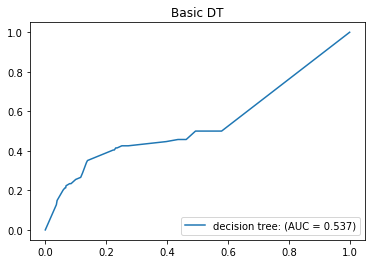

In [88]:
clf = DecisionTreeClassifier()
clf = clf.fit(Xtrain, ytrain)
dt_predict = clf.predict_proba(Xtest)[:,1]
dt_fpr, dt_tpr, thresholds = roc_curve(ytest, dt_predict)
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.plot(dt_fpr, dt_tpr, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc)
plt.title('Basic DT')
plt.legend(loc="lower right")

# Optimization 1
To avoid overfitting, change minimum number of samples in a leaf node (min_samples_leaf) or maximum depth of the tree (max_depth) and do a cross validation to find optimal number for them.

In [8]:
rg_grid = DecisionTreeClassifier()
max_depth_range = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_leaf_range = [1, 2, 4, 8, 10]
param_grid = dict(max_depth=max_depth_range, min_samples_leaf = min_samples_leaf_range)

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid = GridSearchCV(rg_grid, param_grid, cv = kfold, scoring = 'roc_auc')
grid.fit(Xtrain, ytrain)
print ('Best AUC and parameters:')
print (grid.best_score_, grid.best_params_)

Best AUC and parameters:
0.7111282890692457 {'max_depth': 40, 'min_samples_leaf': 8}


In [9]:
# Optimization 1
clf_opt = DecisionTreeClassifier(max_depth = grid.best_params_.get('max_depth'), min_samples_leaf = grid.best_params_.get('min_samples_leaf'))
clf_opt = clf_opt.fit(Xtrain, ytrain)

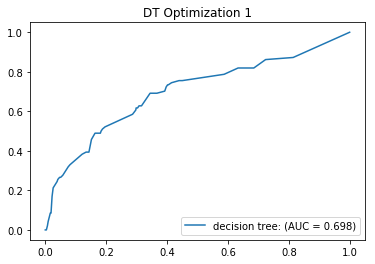

In [10]:
dt_predict_opt = clf_opt.predict_proba(Xtest)[:,1]
dt_fpr_opt, dt_tpr_opt, thresholds = roc_curve(ytest, dt_predict_opt)
dt_roc_auc_opt = auc(dt_fpr_opt, dt_tpr_opt)

plt.plot(dt_fpr_opt, dt_tpr_opt, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc_opt)
plt.title('DT Optimization 1')
plt.legend(loc="lower right")

In [11]:
feature_importance_basic = clf.feature_importances_
len(feature_importance_basic)

41

In [12]:
numOfImportantFeature_basic = np.count_nonzero(feature_importance_basic)
numOfImportantFeature_basic

40

In [13]:
feature_importance = clf_opt.feature_importances_
len(feature_importance)

41

In [14]:
numOfImportantFeature = np.count_nonzero(feature_importance)
numOfImportantFeature

36

In [15]:
important_features = np.argsort(feature_importance)
important_features = important_features[-numOfImportantFeature:]
important_features

array([21, 22, 23, 27, 35,  4, 38, 29, 19, 15, 31, 18, 33, 11, 30, 36, 28,
        0, 16, 26,  6, 10, 12, 20, 39,  9,  1, 17, 40, 37,  8, 34,  3,  7,
        5,  2])

In [16]:
cols_dt = [X.columns[i] for i in important_features]
cols_dt

['Food Delivery Services',
 'Food Stands',
 'Food Trucks',
 'Ice Cream & Frozen Yogurt',
 'Shopping',
 'Arts & Entertainment',
 'Sports Bars',
 'Lounges',
 'Event Planning & Services',
 'Cocktail Bars',
 'Pubs',
 'Diners',
 'Salad',
 'Buffets',
 'Nightlife',
 'Soup',
 'Juice Bars & Smoothies',
 'BusinessParking_street',
 'Coffee & Tea',
 'Hawaiian',
 'Bakeries',
 'Breakfast & Brunch',
 'Cafes',
 'Food',
 'Steakhouses',
 'Beer',
 'BusinessParking_validated',
 'Desserts',
 'Sushi Bars',
 'Specialty Food',
 'Bars',
 'Seafood',
 'class',
 'Barbeque',
 'Asian Fusion',
 'BusinessParking_valet']

In [17]:
fi = pd.DataFrame({'feature': list(Xtrain.columns),
                   'importance': feature_importance}).\
                    sort_values('importance', ascending = False)
print(fi.head())

                  feature  importance
2   BusinessParking_valet    0.169320
5            Asian Fusion    0.099016
7                Barbeque    0.085775
3                   class    0.059494
34                Seafood    0.058088


# Optimization 2

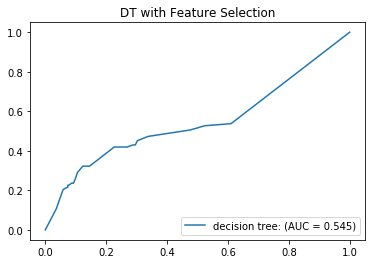

In [18]:
newX = datafinal[cols_dt]
newY = datafinal['success']

newXtrain, newXtest, newytrain, newytest = train_test_split(newX, newY, train_size = 0.75)
clf_fs = DecisionTreeClassifier()
clf_fs = clf_fs.fit(newXtrain, newytrain)

dt_predict = clf_fs.predict_proba(newXtest)[:,1]
dt_fpr, dt_tpr, thresholds = roc_curve(newytest, dt_predict)
dt_roc_auc = auc(dt_fpr, dt_tpr)

plt.plot(dt_fpr, dt_tpr, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc)
plt.title('DT with Feature Selection')
plt.legend(loc="lower right")

In [19]:
rg_grid = DecisionTreeClassifier()
max_depth_range = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_leaf_range = [1, 2, 4, 8, 10]
param_grid = dict(max_depth=max_depth_range, min_samples_leaf = min_samples_leaf_range)

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
grid2 = GridSearchCV(rg_grid, param_grid, cv = kfold, scoring = 'roc_auc')
grid2.fit(newXtrain, ytrain)
print ('Best AUC and parameters:')
print (grid2.best_score_, grid2.best_params_)

Best AUC and parameters:
0.5497514223046094 {'max_depth': 10, 'min_samples_leaf': 2}


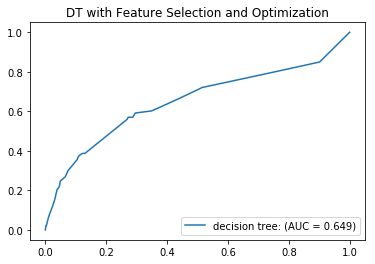

In [20]:
# Third Run {with feature selection and Optimization 2}
clf_opt2 = DecisionTreeClassifier(max_depth = grid2.best_params_.get('max_depth'), min_samples_leaf = grid2.best_params_.get('min_samples_leaf'))
clf_opt2 = clf_opt2.fit(newXtrain, newytrain)
feature_importance2 = clf_opt2.feature_importances_
dt_predict_opt2 = clf_opt2.predict_proba(newXtest)[:,1]
dt_fpr_opt2, dt_tpr_opt2, thresholds = roc_curve(newytest, dt_predict_opt2)
dt_roc_auc_opt2 = auc(dt_fpr_opt2, dt_tpr_opt2)

plt.plot(dt_fpr_opt2, dt_tpr_opt2, label = 'decision tree: (AUC = %0.3f)' % dt_roc_auc_opt2)
plt.title('DT with Feature Selection and Optimization')
plt.legend(loc="lower right")

In [21]:
fi_e = pd.DataFrame({'Feature': list(newXtrain.columns),
                   'Importance': feature_importance2}).\
                    sort_values('Importance', ascending = False)
print(fi_e.head(20))

                      Feature  Importance
35      BusinessParking_valet    0.107074
34               Asian Fusion    0.074891
32                      class    0.065795
18               Coffee & Tea    0.063703
26  BusinessParking_validated    0.061095
29             Specialty Food    0.060461
21         Breakfast & Brunch    0.049170
27                   Desserts    0.045551
25                       Beer    0.045503
30                       Bars    0.039160
23                       Food    0.038771
15                       Soup    0.035277
24                Steakhouses    0.034185
31                    Seafood    0.034111
22                      Cafes    0.032497
17     BusinessParking_street    0.030877
33                   Barbeque    0.029339
28                 Sushi Bars    0.028363
14                  Nightlife    0.027299
0      Food Delivery Services    0.025508


### Decision Tree vizualization

In [ ]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(clf_opt, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=False, feature_names=Xtrain.columns)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

# Random Forest

In [22]:
X = datafinal[important_cols]
Y = datafinal['success']
Xtrain_rf, Xtest_rf, ytrain_rf, ytest_rf = train_test_split(X, Y, train_size = 0.75)

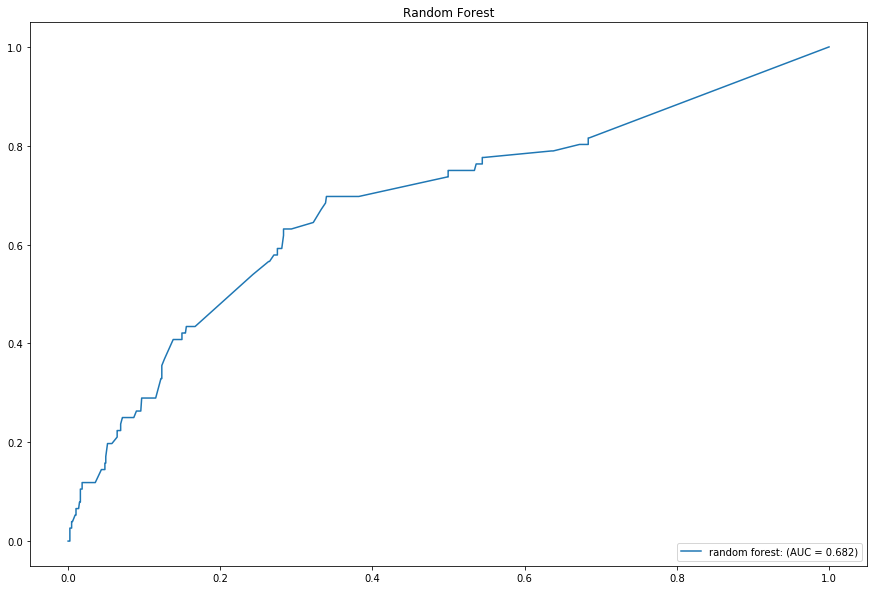

In [110]:
rf = RandomForestClassifier()
rf = rf.fit(Xtrain_rf, ytrain_rf)
rf0_predict = rf.predict_proba(Xtest_rf)[:,1]
rf0_fpr, rf0_tpr, thresholds = roc_curve(ytest_rf, rf0_predict)
rf0_roc_auc = auc(rf0_fpr, rf0_tpr)

plt.plot(rf0_fpr, rf0_tpr, label = 'random forest: (AUC = %0.3f)' % rf0_roc_auc)
plt.title('Random Forest')
plt.legend(loc="lower right")

In [24]:
feature_importance_rf = rf.feature_importances_
numOfImportantFeature_rf = np.count_nonzero(feature_importance_rf)
print("Number of important features: ")
print(numOfImportantFeature_rf)
important_features_rf = np.argsort(feature_importance_rf)
important_features_rf[-numOfImportantFeature_rf:]
importantCols_rf = [data.columns[i + 16] for i in important_features_rf[-numOfImportantFeature_rf:]]
print("Important Columns:")
print(importantCols_rf)
fi_e = pd.DataFrame({'Feature': list(Xtrain_rf.columns),
                   'Importance': feature_importance_rf}).\
                    sort_values('Importance', ascending = False)
print(fi_e.head(20))

Number of important features: 
40
Important Columns:
['Music_dj', 'Caters', 'BestNights_monday', 'GoodForMeal_brunch', 'BusinessParking_lot', 'RestaurantsDelivery', 'GoodForMeal_latenight', 'DriveThru', 'BestNights_friday', 'NoiseLevel', 'HappyHour', 'BestNights_saturday', 'BestNights_thursday', 'GoodForDancing', 'BestNights_sunday', 'WiFi', 'RestaurantsAttire', 'Alcohol', 'CoatCheck', 'BestNights_tuesday', 'GoodForKids', 'RestaurantsReservations', 'OutdoorSeating', 'BestNights_wednesday', 'Smoking', 'BusinessAcceptsCreditCards', 'DogsAllowed', 'BikeParking', 'HasTV', 'WheelchairAccessible', 'BusinessAcceptsBitcoin', 'GoodForMeal_breakfast', 'GoodForMeal_dinner', 'RestaurantsTakeOut', 'GoodForMeal_dessert', 'BusinessParking_garage', 'RestaurantsTableService', 'BusinessParking_valet', 'BusinessParking_street', 'BusinessParking_validated']
                      Feature  Importance
3                       class    0.081280
2       BusinessParking_valet    0.075607
5                Asian F

In [25]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [26]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 675
Average maximum depth 30


In [27]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [28]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(Xtrain_rf, ytrain_rf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [29]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

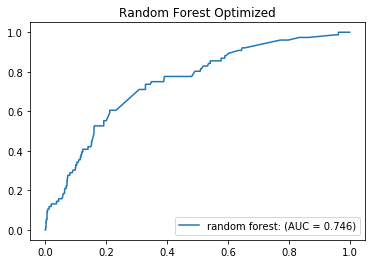

In [92]:
rf1 = RandomForestClassifier(max_depth= rf_random.best_params_.get('max_depth'), 
                             min_samples_leaf=rf_random.best_params_.get('min_samples_leaf'), 
                             min_samples_split=rf_random.best_params_.get('min_samples_split'), 
                             n_estimators=rf_random.best_params_.get('n_estimators'))
rf1 = rf1.fit(Xtrain_rf, ytrain_rf)
rf_predict1 = rf1.predict_proba(Xtest_rf)[:,1]
rf1_fpr, rf1_tpr, thresholds = roc_curve(ytest_rf, rf_predict1)
rf1_roc_auc = auc(rf1_fpr, rf1_tpr)

plt.plot(rf1_fpr, rf1_tpr, label = 'random forest: (AUC = %0.3f)' % rf1_roc_auc)
plt.title('Random Forest Optimized')
plt.legend(loc="lower right")

In [93]:
n_nodes = []
max_depths = []

for ind_tree in rf1.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 106
Average maximum depth 10


### Log Reg

Standard VS. Using feature selection from DT

In [32]:
random.seed(1)
X = datafinal[important_cols]
Y = datafinal['success']
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X, Y, train_size = 0.75)

X_dt = datafinal[cols_dt]
Y = datafinal['success']
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X_dt, Y, train_size = 0.75)

Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.91


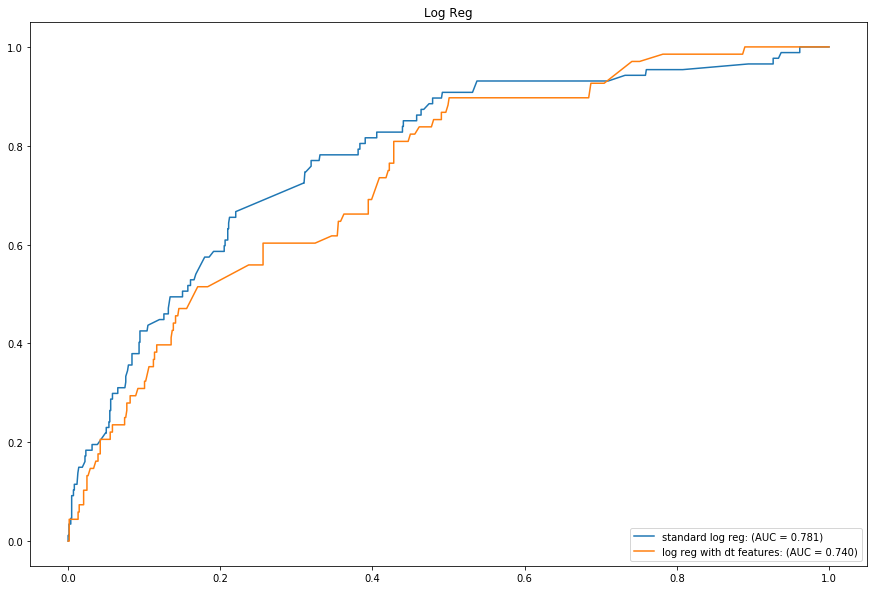

In [107]:
#Standard
lr = LogisticRegression()
lr.fit(Xtrain1, ytrain1)
y_pred = lr.predict(Xtest1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

lr_predict0 = lr.predict_proba(Xtest1)[:,1]
lr0_fpr, lr0_tpr, thresholds = roc_curve(ytest1, lr_predict0)
lr0_roc_auc = auc(lr0_fpr, lr0_tpr)

#With features from DT
lr = LogisticRegression()
lr.fit(Xtrain2, ytrain2)
y_pred_dt = lr.predict(Xtest2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest2, ytest2)))

lr_predict_dt = lr.predict_proba(Xtest2)[:,1]
lr_fpr2, lr_tpr2, thresholds = roc_curve(ytest2, lr_predict_dt)
lr_roc_auc_2 = auc(lr_fpr2, lr_tpr2)

plt.plot(lr0_fpr, lr0_tpr, label = 'standard log reg: (AUC = %0.3f)' % lr0_roc_auc)
plt.plot(lr_fpr2, lr_tpr2, label = 'log reg with dt features: (AUC = %0.3f)' % lr_roc_auc_2)
plt.title('Log Reg')
plt.legend(loc="lower right")

### LR Result Summary

In [34]:
import statsmodels.api as sm
logit_model=sm.Logit(ytrain2,Xtrain2)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.283270
         Iterations: 35
                                    Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.048     
Dependent Variable:         success                 AIC:                     1677.5772 
Date:                       2019-12-06 15:38        BIC:                     1891.7572 
No. Observations:           2834                    Log-Likelihood:          -802.79   
Df Model:                   35                      LL-Null:                 -843.29   
Df Residuals:               2798                    LLR p-value:             1.6478e-05
Converged:                  0.0000                  Scale:                   1.0000    
No. Iterations:             35.0000                                                    
---------------------------------------------------------------------------------------
                           Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
---

In [35]:
logit_model=sm.Logit(ytrain1,Xtrain1)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.250821
         Iterations: 35
                                   Results: Logit
Model:                     Logit                  Pseudo R-squared:       0.145     
Dependent Variable:        success                AIC:                    1503.6541 
Date:                      2019-12-06 15:38       BIC:                    1747.5814 
No. Observations:          2834                   Log-Likelihood:         -710.83   
Df Model:                  40                     LL-Null:                -831.54   
Df Residuals:              2793                   LLR p-value:            1.3128e-30
Converged:                 0.0000                 Scale:                  1.0000    
No. Iterations:            35.0000                                                  
------------------------------------------------------------------------------------
                           Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
----------------------------------

### Log Reg with optimization

Start with using all features, then also use features rec by DT

In [36]:
X_dt = X[cols_dt]
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X_dt, Y, train_size = 0.75)

In [37]:
data = [X_dt,Y]
data = pd.concat(data, axis=1)

In [38]:
# Find the optimal C: 
random.seed(1)
cs = [10**c for c in range(-8, 2)]
# tols = [10**c for c in range(-10, 1)]
auc_cv = {c:[] for c in cs}
kf = KFold(n_splits=5, random_state=1) 

for train_set_kf, val_set_kf in kf.split(data): 
    cv_train, cv_validate = data.iloc[train_set_kf], data.iloc[val_set_kf]
    Xtrain2, Xtest2 = cv_train.drop('success',1), cv_validate.drop('success',1)
    ytrain2, ytest2 = cv_train['success'].astype('int'), cv_validate['success'].astype('int')

    for c in cs:
    #print(c)
  
        lr = LogisticRegression(C=c)
        lr_fit = lr.fit(Xtrain2, ytrain2)
        lr_preds = lr_fit.predict_proba(Xtest2)[:,1]
        fpr, tpr, thresholds = roc_curve(ytest2,lr_preds)

    #print(auc(fpr,tpr))

        auc_cv[c].append(auc(fpr,tpr))

print(auc_cv)


{1e-08: [0.3816014160766348, 0.4181035564591019, 0.40673732943469787, 0.39284907875722547, 0.3695200787738676], 1e-07: [0.3816014160766348, 0.4181035564591019, 0.4067677875243665, 0.392894237716763, 0.3695093758027228], 1e-06: [0.38159100374843813, 0.4181035564591019, 0.4067677875243665, 0.392894237716763, 0.3695093758027228], 1e-05: [0.3817367763431903, 0.4181286549707602, 0.40747847628330086, 0.39271360187861276, 0.36950937580272286], 0.0001: [0.38217409412744696, 0.41933338353035654, 0.4106461176088369, 0.3930748735549134, 0.3696806233410395], 0.001: [0.3927946688879633, 0.44495896393343876, 0.43101242690058483, 0.4073676842485549, 0.3805548420241459], 0.01: [0.5468763015410245, 0.6310644278794266, 0.630045890188434, 0.5818167449421966, 0.5028041784399349], 0.1: [0.7233652644731362, 0.7310819968375875, 0.7651985867446394, 0.7359216943641619, 0.6931030053942975], 1: [0.7473760932944606, 0.7565318876590618, 0.7713308154645873, 0.7472565932080926, 0.7403673259696892], 10: [0.7437734277

Text(0, 0.5, 'Mean Val AUC')

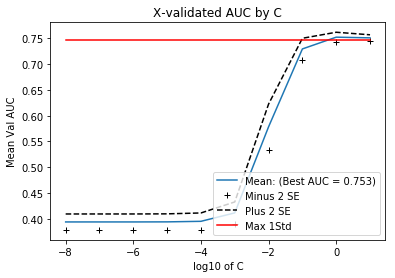

In [39]:
d = {'c':[], 'mean':[], 'se':[]}
for c in cs:
    d['c'].append(c)
    d['mean'].append(np.array(auc_cv[c]).mean()) # mean
    d['se'].append(np.sqrt(np.array(auc_cv[c]).var()/len(auc_cv[c]))) # sqrt(Var(X)/N)

df = pd.DataFrame(d)
df['lower'] = df['mean']-2*df['se']
df['upper'] = df['mean']+2*df['se']
#print(df)

max_1std_m = df['mean'].max()
max_1std_se = float(df[df['mean']==max_1std_m]['se'])
ref = [max_1std_m-max_1std_se]*10
c_lr = df[df['mean']==max_1std_m]['c']
log_c = [np.log10(c) for c in cs]

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(log_c, df['mean'], label = 'Mean: (Best AUC = %0.3f)' % max_1std_m)
plt.plot(log_c, df['lower'], 'k+', label ="Minus 2 SE")
plt.plot(log_c, df['upper'], 'k--', label ="Plus 2 SE")
plt.plot(log_c, ref, 'r', label ="Max 1Std")
plt.legend(loc="lower right")

plt.title('X-validated AUC by C')
ax.set_xlabel('log10 of C')
ax.set_ylabel('Mean Val AUC')

# c=1 is best
#AUC = 0.838

In [40]:
print(df)

              c      mean        se     lower     upper
0  1.000000e-08  0.393762  0.007739  0.378285  0.409240
1  1.000000e-07  0.393775  0.007742  0.378291  0.409259
2  1.000000e-06  0.393773  0.007743  0.378288  0.409259
3  1.000000e-05  0.393913  0.007786  0.378341  0.409486
4  1.000000e-04  0.394982  0.008115  0.378752  0.411211
5  1.000000e-03  0.411338  0.010630  0.390079  0.432597
6  1.000000e-02  0.578522  0.022055  0.534411  0.622632
7  1.000000e-01  0.729734  0.010354  0.709026  0.750442
8  1.000000e+00  0.752573  0.004782  0.743008  0.762137
9  1.000000e+01  0.751239  0.002964  0.745311  0.757167


Accuracy of logistic regression classifier on test set: 0.91


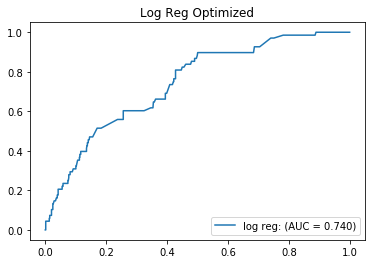

In [90]:
lr1 = LogisticRegression(C=1)
lr1.fit(Xtrain2, ytrain2) # feature importances from decision tree
y_pred = lr1.predict(Xtest2)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr1.score(Xtest2, ytest2)))

lr_predict1 = lr1.predict_proba(Xtest2)[:,1]
lr1_fpr, lr1_tpr, thresholds = roc_curve(ytest2, lr_predict1)
lr1_roc_auc = auc(lr1_fpr, lr1_tpr)

plt.plot(lr1_fpr, lr1_tpr, label = 'log reg: (AUC = %0.3f)' % lr1_roc_auc)
plt.title('Log Reg Optimized')
plt.legend(loc="lower right")

### Log Reg by Cuisine (no optimization or feature selection)


In [48]:
#Run LR for each cuisine with all features
#Need to load cuisine data in and do some prep again
data = pd.read_csv('vegas_cuisine.csv')
cuisine = ['asian', 'namerica', 'samerica', 'european', 'other']
cuisine_df = data[cuisine]
data_cuisine = [X,Y,cuisine_df]
data_cuisine = pd.concat(data_cuisine, axis=1)

len(data_cuisine.columns)

47

In [125]:
def run_lr(data, cuisine, feature_select = None, c=1):

    temp = data[data[cuisine] == True]
  
    if feature_select == None:

        X = temp.drop('success',1) # confirm cols
        Y = temp['success']
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

    else:

        X = temp.drop('success',1) # confirm cols
        Y = temp['success']
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

    lr = LogisticRegression(C=c)
    lr.fit(Xtrain, ytrain) # without feature selection
  # result=logit_model.fit()
  # print(result.summary2())
    y_pred = lr.predict(Xtest)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

    lr_predict = lr.predict_proba(Xtest)[:,1]
    lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
    lr_roc_auc = auc(lr_fpr, lr_tpr)

    plt.plot(lr_fpr, lr_tpr, label = cuisine+' LR: (AUC = %0.3f)' % lr_roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Log Reg')
    plt.legend(loc="lower right")

    return plt

In [126]:
def run_reg(data, cuisine, feature_select = None):

    temp = data[data[cuisine] == True]
  
    if feature_select == None:

        X = temp.drop('success',1) # confirm cols
        Y = temp['success']
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

    else:

        X = temp.drop('success',1) # confirm cols
        Y = temp['success']
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

    lr = LogisticRegression(penalty = 'l1')
    lr.fit(Xtrain, ytrain) # without feature selection
  # result=logit_model.fit()
  # print(result.summary2())
    y_pred = lr.predict(Xtest)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

    lr_predict = lr.predict_proba(Xtest)[:,1]
    lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
    lr_roc_auc = auc(lr_fpr, lr_tpr)

    plt.plot(lr_fpr, lr_tpr, label = cuisine+' LR: (AUC = %0.3f)' % lr_roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Log Reg')
    plt.legend(loc="lower right")



    return plt

Accuracy of logistic regression classifier on test set: 0.88
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.84


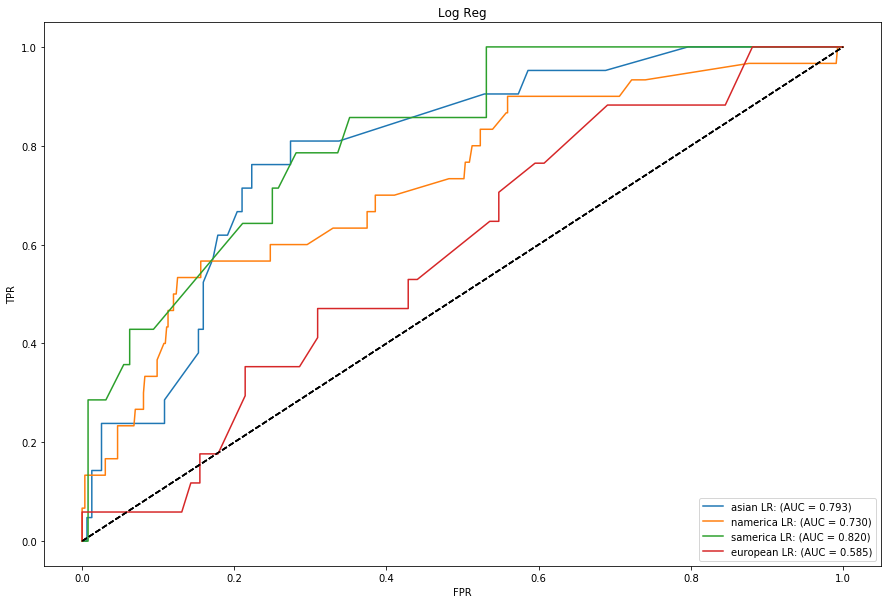

In [127]:
for i in ['asian', 'namerica', 'samerica', 'european']:
    run_lr(data_cuisine, i)

Accuracy of logistic regression classifier on test set: 0.88
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.83


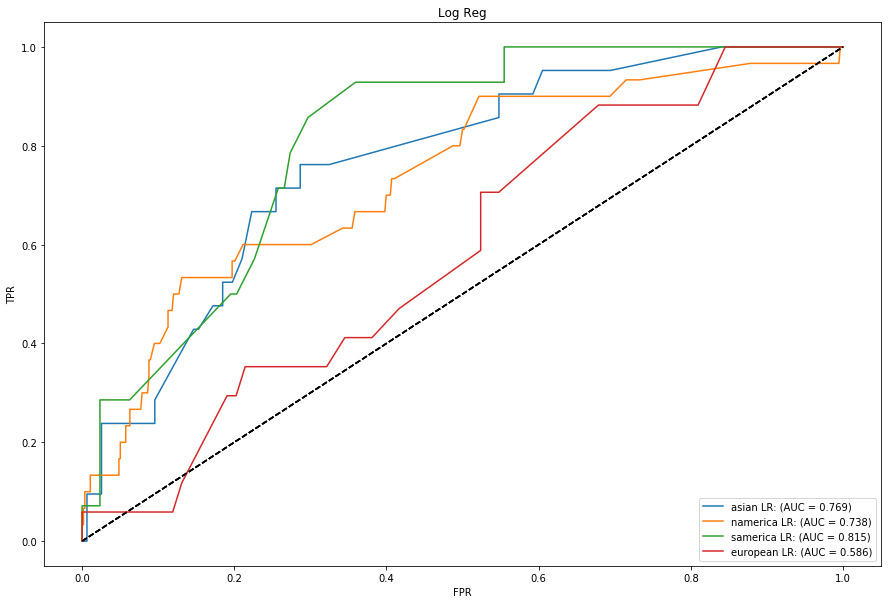

In [128]:
for i in ['asian', 'namerica', 'samerica', 'european']:
    run_reg(data_cuisine, i)

#### LR for each cuisine with DT features

In [131]:
def run_lr_dt(data, cuisine, feature_select = None, c=1):

  temp = data[data[cuisine] == True]
  
  if feature_select == None:

    X = temp[cols_dt] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  else:

    X = temp[feature_select] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  lr = LogisticRegression(C=c)
  lr.fit(Xtrain, ytrain) # without feature selection
  # result=logit_model.fit()
  # print(result.summary2())
  y_pred = lr.predict(Xtest)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(Xtest, ytest)))

  lr_predict = lr.predict_proba(Xtest)[:,1]
  lr_fpr, lr_tpr, thresholds = roc_curve(ytest, lr_predict)
  lr_roc_auc = auc(lr_fpr, lr_tpr)

  plt.plot(lr_fpr, lr_tpr, label = cuisine+' LR: (AUC = %0.3f)' % lr_roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('Log Reg')
  plt.legend(loc="lower right")

  return plt

Accuracy of logistic regression classifier on test set: 0.89
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.84


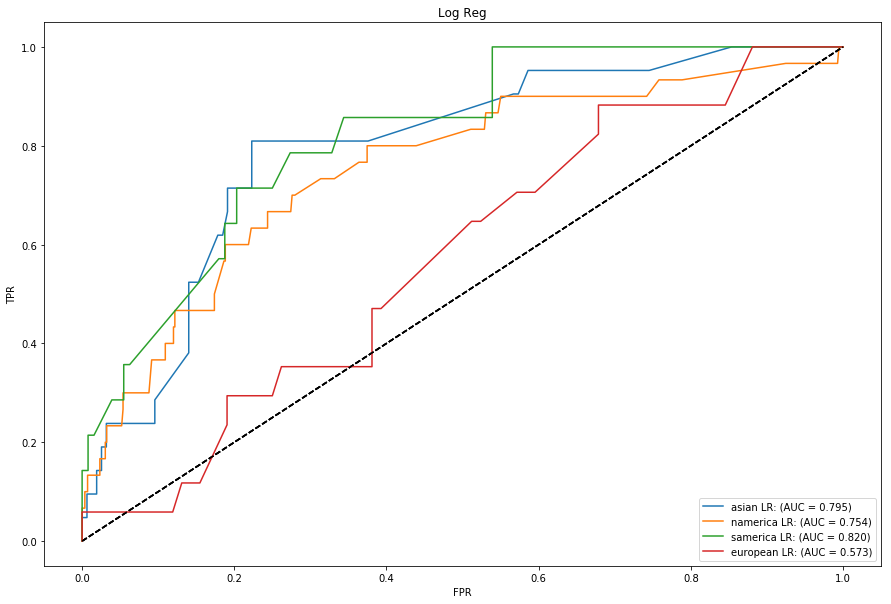

In [132]:
for i in ['asian', 'namerica', 'samerica', 'european']:
  run_lr_dt(data_cuisine, i)

#### LR by cuisine with feature selection and optimization:

In [133]:
# Find the optimal C: 

cs = [10**c for c in range(-8, 2)]
auc_cv = {c:[] for c in cs}
kf = KFold(n_splits=5, random_state=1) 

d=datafinal[datafinal['namerica'] == True].iloc[:,16:]

for train_set_kf, val_set_kf in kf.split(d): 
  cv_train, cv_validate = d.iloc[train_set_kf], d.iloc[val_set_kf]
  X_train, X_test = cv_train.drop('success',1), cv_validate.drop('success',1)
  y_train, y_test = cv_train['success'].astype('int'), cv_validate['success'].astype('int')

  for c in cs:
    #print(c)
  
    lr = LogisticRegression(C=c)
    lr_fit = lr.fit(X_train, y_train)
    lr_preds = lr_fit.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test,lr_preds)

    #print(auc(fpr,tpr))

    auc_cv[c].append(auc(fpr,tpr))

print(auc_cv)


{1e-08: [0.34625, 0.30935706643322636, 0.35851685393258426, 0.347191011235955, 0.3796775536914749], 1e-07: [0.34625, 0.30950296663748655, 0.35856179775280894, 0.34723595505617977, 0.3799750133856863], 1e-06: [0.34625, 0.30950296663748655, 0.35856179775280894, 0.34723595505617977, 0.3799750133856863], 1e-05: [0.34624999999999995, 0.3095029666374866, 0.35856179775280894, 0.3473258426966292, 0.38003450532452854], 0.0001: [0.3482954545454545, 0.30989203384884734, 0.3590112359550562, 0.3480449438202247, 0.38051044083526686], 0.001: [0.3539015151515152, 0.31611710923061953, 0.3633258426966292, 0.35253932584269665, 0.38396097328811946], 0.01: [0.4504166666666667, 0.515805855461531, 0.5493932584269663, 0.542561797752809, 0.4921768100422393], 0.1: [0.7985227272727272, 0.8115942028985508, 0.8092584269662922, 0.7656629213483146, 0.7639359866738057], 1: [0.8114015151515152, 0.8093570664332262, 0.7968539325842696, 0.7512808988764045, 0.8001665774287584], 10: [0.7940530303030304, 0.7455500437700613,

In [134]:
# Find the optimal C: 
def optimal_c(cusine_type):
  cs = [10**c for c in range(-8, 2)]
  auc_cv = {c:[] for c in cs}
  kf = KFold(n_splits=5, random_state=1) 

  d=datafinal[datafinal[cusine_type] == True].iloc[:,16:]

  for train_set_kf, val_set_kf in kf.split(d): 
    cv_train, cv_validate = d.iloc[train_set_kf], d.iloc[val_set_kf]
    X_train, X_test = cv_train.drop('success',1), cv_validate.drop('success',1)
    y_train, y_test = cv_train['success'].astype('int'), cv_validate['success'].astype('int')

    for c in cs:
      #print(c)
    
      lr = LogisticRegression(C=c)
      lr_fit = lr.fit(X_train, y_train)
      lr_preds = lr_fit.predict_proba(X_test)[:,1]
      fpr, tpr, thresholds = roc_curve(y_test,lr_preds)

      #print(auc(fpr,tpr))

      auc_cv[c].append(auc(fpr,tpr))

  return auc_cv

def optimal_c_plot(auc_cv):
  d = {'c':[], 'mean':[], 'se':[]}
  for c in cs:
      d['c'].append(c)
      d['mean'].append(np.array(auc_cv[c]).mean()) # mean
      d['se'].append(np.sqrt(np.array(auc_cv[c]).var()/len(auc_cv[c]))) # sqrt(Var(X)/N)

  df = pd.DataFrame(d)
  df['lower'] = df['mean']-2*df['se']
  df['upper'] = df['mean']+2*df['se']
  #print(df)
  optim_c_val = df.iloc[np.where(df['mean']==df['mean'].max())]['c']
  print('The optimal c value = %0.1f' %optim_c_val)


  max_1std_m = df['mean'].max()
  max_1std_se = float(df[df['mean']==max_1std_m]['se'])
  ref = [max_1std_m-max_1std_se]*10
  c_lr = df[df['mean']==max_1std_m]['c']
  log_c = [np.log10(c) for c in cs]

  fig = plt.figure()
  ax = fig.add_subplot(111)

  plt.plot(log_c, df['mean'], label = 'Mean: (Best AUC = %0.3f)' % max_1std_m)
  plt.plot(log_c, df['lower'], 'k+', label ="Minus 2 SE")
  plt.plot(log_c, df['upper'], 'k--', label ="Plus 2 SE")
  plt.plot(log_c, ref, 'r', label ="Max 1Std")
  plt.legend(loc="lower right")
  #print(df)

  #plt.title('X-validated AUC by C')
  ax.set_xlabel('log10 of C')
  ax.set_ylabel('Mean Val AUC')

The optimal c value = 1.0


Text(0.5, 1.0, 'X-validated AUC by C: namerica')

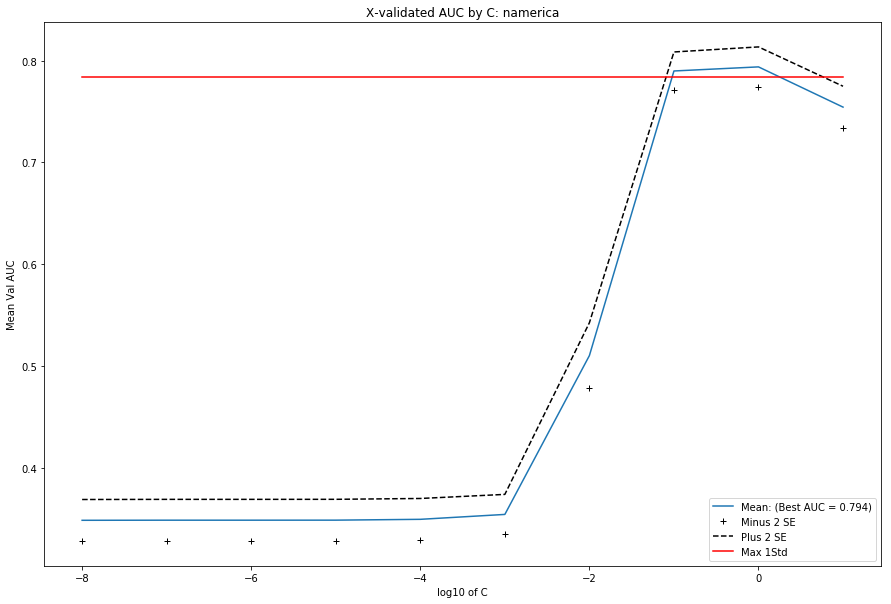

In [135]:
na_c = optimal_c('namerica')
optimal_c_plot(na_c)
plt.title('X-validated AUC by C: namerica')

The optimal c value = 1.0
The optimal c value = 1.0
The optimal c value = 1.0
The optimal c value = 1.0


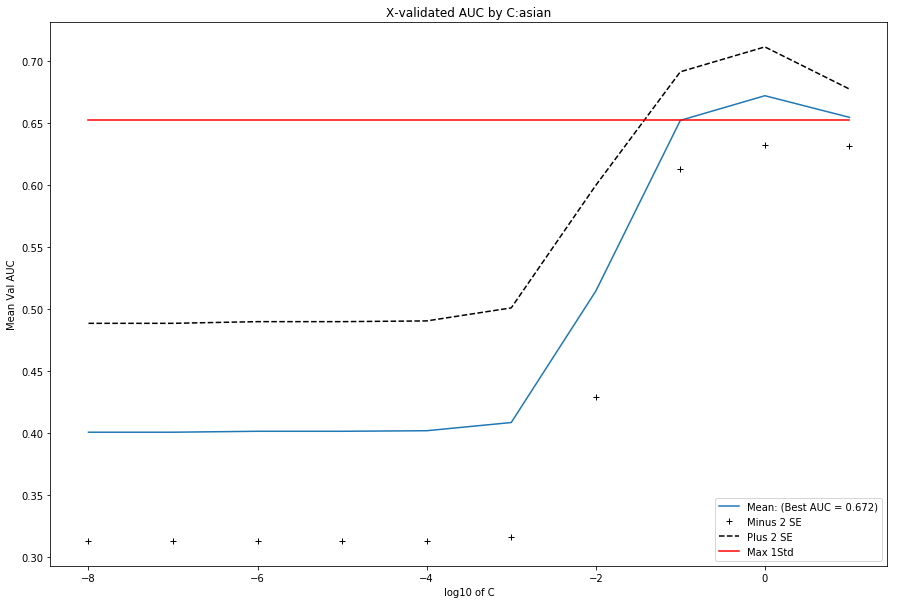

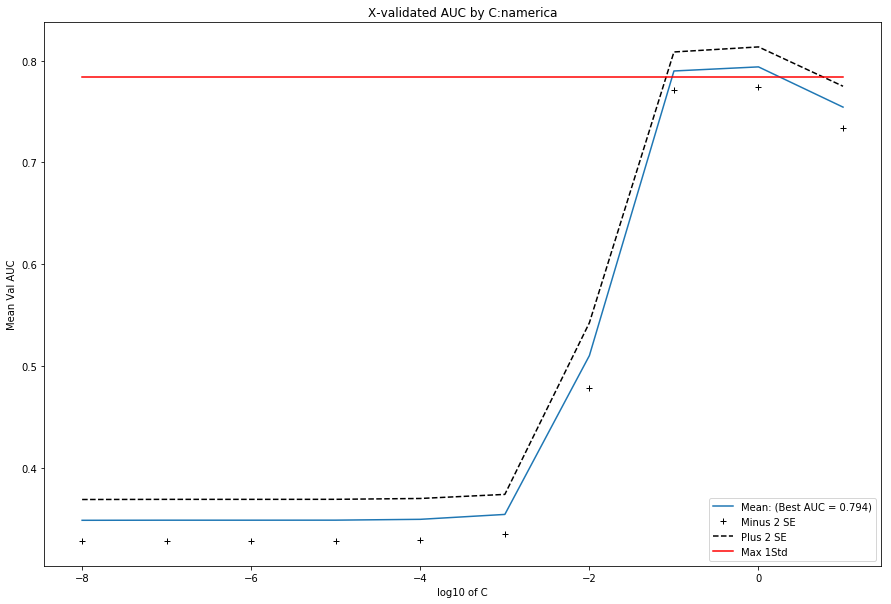

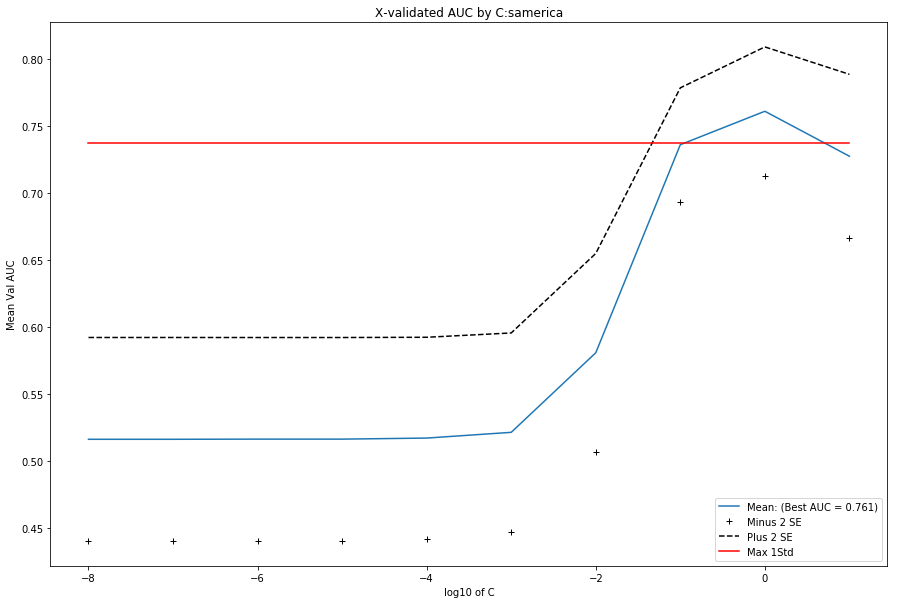

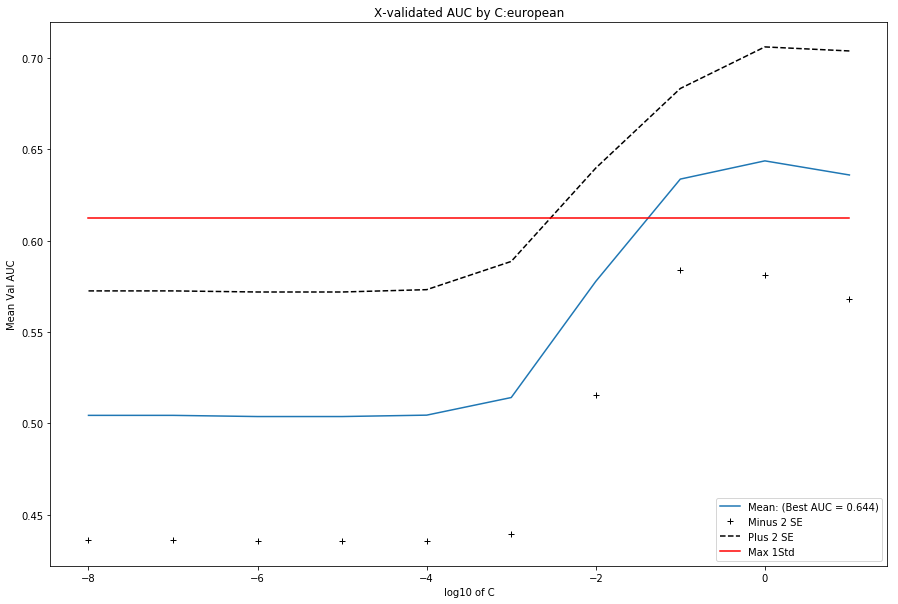

In [136]:
#loop
for i in ['asian', 'namerica', 'samerica', 'european']:
  temp = optimal_c(i)
  optimal_c_plot(temp)
  plt.title('X-validated AUC by C:%s' %i)

#NOTE: 1 has been added as a parameter to the function above!

### Log Reg with feature selection: 
Using built-in function of Log Reg to select features

Accuracy of logistic regression classifier on test set: 0.88
Accuracy of logistic regression classifier on test set: 0.95
Accuracy of logistic regression classifier on test set: 0.90
Accuracy of logistic regression classifier on test set: 0.84


['20.Food',
 '1.BusinessParking_validated',
 '5.Asian Fusion',
 '26.Hawaiian',
 '14.Caterers',
 '9.Beer',
 '19.Event Planning & Services',
 '28.Juice Bars & Smoothies',
 '30.Nightlife',
 '21.Food Delivery Services',
 '18.Diners',
 '16.Coffee & Tea',
 '2.BusinessParking_valet',
 '13.Casinos',
 '29.Lounges',
 '12.Cafes',
 '24.Gluten-Free',
 '4.Arts & Entertainment',
 '3.class',
 '22.Food Stands',
 '15.Cocktail Bars',
 '23.Food Trucks',
 '7.Barbeque',
 '6.Bakeries',
 '11.Buffets',
 '27.Ice Cream & Frozen Yogurt',
 '31.Pubs',
 '17.Desserts',
 '10.Breakfast & Brunch',
 '32.Restaurants',
 '8.Bars',
 '25.Grocery']

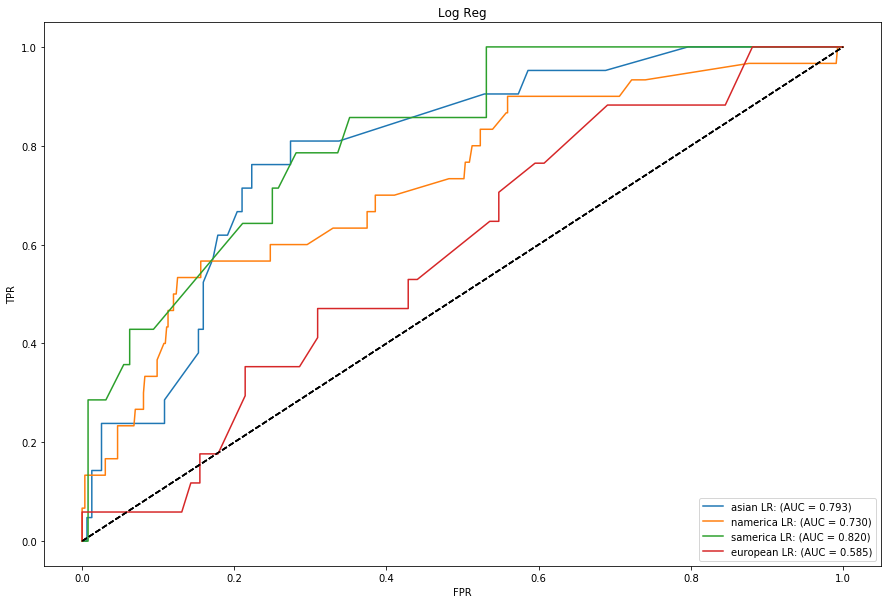

In [137]:
#Feature selection

from sklearn.feature_selection import RFE
#Define a function to output important features based on RFE

def get_nfeature(data, cuisine,  nfeatures,feature_select = None):
  temp = data[data[cuisine] == True]
  
  if feature_select == None:

    X = temp.iloc[:, 16:-1] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)

  else:

    X = temp[feature_select] # confirm cols
    Y = temp['success']
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, train_size = 0.75, random_state = 0)
  
  lr = LogisticRegression()
  selector = RFE(lr, n_features_to_select = nfeatures)
  selector = selector.fit( Xtrain,ytrain)

  order = selector.ranking_
  feature_rank = []
  for i in order:
    feature_rank.append(f"{i}.{Xtrain.columns[i]}")

  return feature_rank


for i in ['asian', 'namerica', 'samerica', 'european']:
  run_lr(data_cuisine, i, feature_select=important_cols)

#Print most important features for Asian res

feature_rank = get_nfeature(data_cuisine,'asian',10,feature_select=important_cols)
features_sorted = []

for i in feature_rank:
  if i not in features_sorted:
    features_sorted.append(i)

features_sorted

#### Summary for each cuisine

In [138]:
import statsmodels.api as sm

def get_sum(data, cuisine, feature_select = None, c=1):
    temp = data[data[cuisine] == True]
    if feature_select == None:
        X = temp[important_cols] # confirm cols
        Y = temp['success']
    else:
        X = temp[feature_select] # confirm cols
        Y = temp['success']

    logit_model=sm.Logit(Y,X)
    result=logit_model.fit()
    print(result.summary2())

    return plt


In [139]:
get_sum(data_cuisine, 'asian')

         Current function value: 0.362392
         Iterations: 35
                                                          Results: Logit
Model:                                    Logit                                  Pseudo R-squared:                       0.178     
Dependent Variable:                       success                                AIC:                                    596.5964  
Date:                                     2019-12-06 16:35                       BIC:                                    783.7723  
No. Observations:                         710                                    Log-Likelihood:                         -257.30   
Df Model:                                 40                                     LL-Null:                                -312.83   
Df Residuals:                             669                                    LLR p-value:                            1.3206e-08
Converged:                                0.0000                     

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [146]:
get_sum(data_cuisine, 'namerica')

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

### Bootstrapping for LR

In [70]:
import random 
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline

data_train, data_test = train_test_split(data_cuisine, train_size = 0.75, random_state = 0)

In [71]:
data_train.shape

(2834, 47)

In [72]:
cuisine = ['asian','namerica','samerica','european']

In [73]:
#general
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000,2500,3000]

def modBootstrapper(train, test, nruns, sampsize, c):
    auc = []
    for i in range(nruns):
        train_samp = train.sample(n = sampsize, replace=True)
        
        x_train = train_samp[important_cols]
        y_train = train_samp['success']
        
        x_test = test[important_cols]
        y_test = test['success']
        
        LR = LogisticRegression(solver ='lbfgs')
        LR.fit(x_train, y_train)
        y_pred_proba_LR = LR.predict_proba(x_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_pred_proba_LR)

          
        auc.append(roc_auc)
    
    auc_mean = np.mean(auc)
    auc_std = np.sqrt(np.var(auc))
    aucs = [auc_mean, auc_std]
    return aucs

In [74]:

#Choose C= 1 found above
C = 1
def learning_curve(samplesizes,nruns,data_train,data_test,C):
  auc_mean_LR = []
  auc_mean_minus2std_LR =[]
  auc_mean_plus2std_LR =[]
  xs = np.log2(samplesizes)

  for i in samplesizes:
      auc_mean0, auc_std0 = modBootstrapper(data_train, data_test, nruns, i, C)
      auc_mean_LR.append(auc_mean0)
      auc_mean_minus2std_LR.append(auc_mean0 - 2*auc_std0)
      auc_mean_plus2std_LR.append(auc_mean0 + 2*auc_std0)

    
  %matplotlib inline

  fig = plt.figure(figsize = (12, 6))
  ax = plt.subplot(111)

  plt.title('Bootstrapped AUC + Confidence Limits \n as a Function of N Samples')
  plt.plot(xs, auc_mean_LR, 'b', label ='Average AUC for LR')
  plt.plot(xs, auc_mean_minus2std_LR, 'b+', label ='Lower 95% CI for LR')
  plt.plot(xs, auc_mean_plus2std_LR, 'b--', label ='Upper 95% CI for LR')
  plt.xlim([min(xs),max(xs)])       
  plt.xlabel('Log2(N)')
  plt.ylabel('Test Set AUC')
  plt.legend(loc="lower right")


Note: Cannot run a loop for each cuisine since the data size is different

In [75]:
#Create a training and testing set for each cuisine
random.seed(1)

dtrain_A, dtest_A = data_train[data_train['asian']==True], data_test[data_test['asian']==True]
dtrain_E, dtest_E = data_train[data_train['european']==True], data_test[data_test['european']==True]
dtrain_NA, dtest_NA = data_train[data_train['namerica']==True], data_test[data_test['namerica']==True]
dtrain_SA, dtest_SA = data_train[data_train['samerica']==True], data_test[data_test['samerica']==True]

dtrain_A.shape, dtrain_E.shape, dtrain_NA.shape, dtrain_SA.shape
# learning_curve(samplesizes,nruns,data_train,data_test,C)



((535, 47), (298, 47), (1755, 47), (433, 47))

Asian


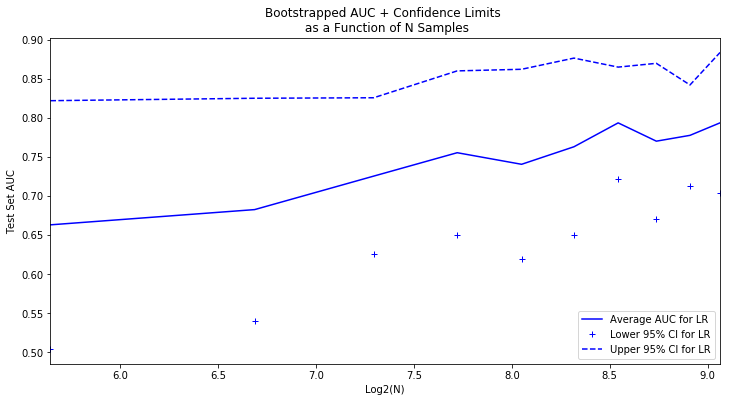

In [142]:
samplesizesA = [int(i) for i in np.linspace(50,535,10)]
samplesizesE = [int(i) for i in np.linspace(50,298,10)]
samplesizesNA = [int(i) for i in np.linspace(50,1755,10)]
samplesizesSA = [int(i) for i in np.linspace(50,433,10)]

nruns = 20
print('Asian')
learning_curve(samplesizesA,nruns,dtrain_A,dtest_A,C)

European


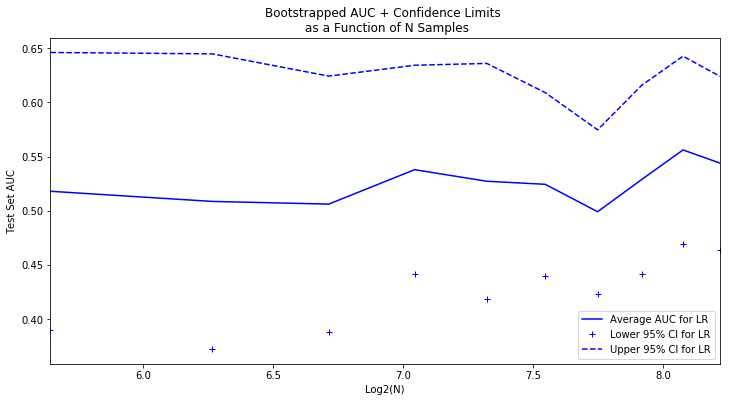

In [143]:
print('European')
learning_curve(samplesizesE,nruns,dtrain_E,dtest_E,C)

North America


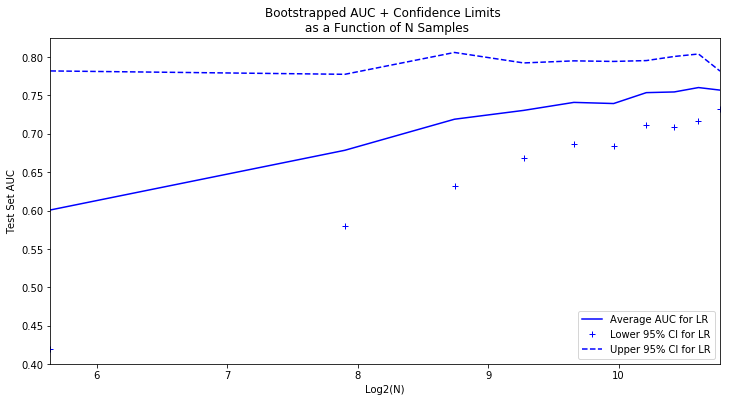

In [144]:
print('North America')
learning_curve(samplesizesNA,nruns,dtrain_NA,dtest_NA,C)

South America


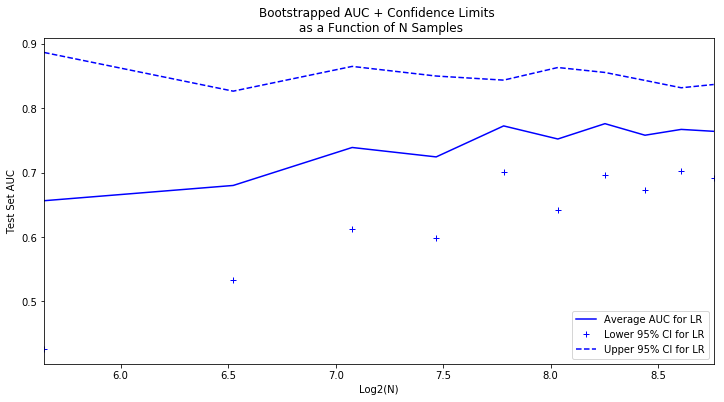

In [145]:
print('South America')
learning_curve(samplesizesSA,nruns,dtrain_SA,dtest_SA,C)

# ROC of best models

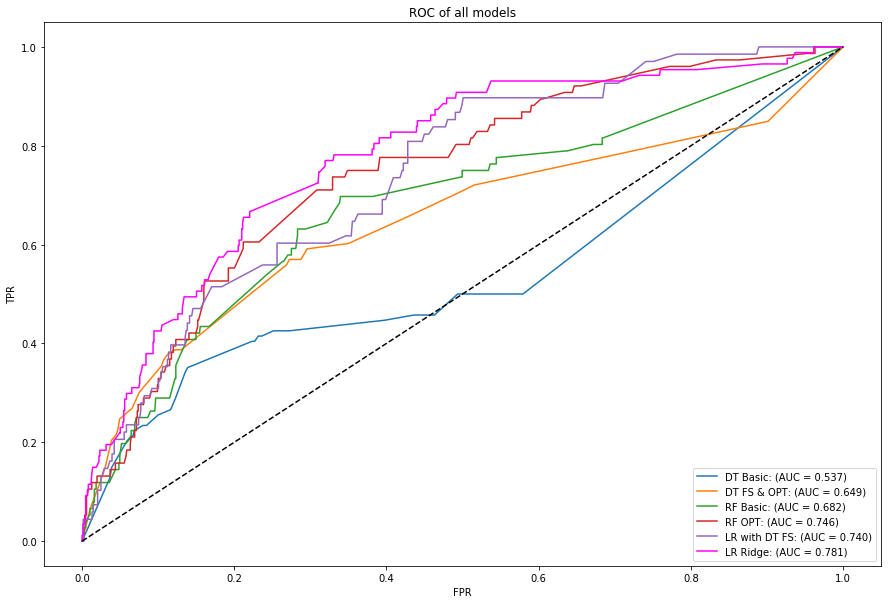

In [123]:
plt.plot(dt_fpr, dt_tpr, label = 'DT Basic: (AUC = %0.3f)' % dt_roc_auc)
plt.plot(dt_fpr_opt2, dt_tpr_opt2, label = 'DT FS & OPT: (AUC = %0.3f)' % dt_roc_auc_opt2)
plt.plot(rf0_fpr, rf0_tpr, label = 'RF Basic: (AUC = %0.3f)' % rf0_roc_auc)
plt.plot(rf1_fpr, rf1_tpr, label = 'RF OPT: (AUC = %0.3f)' % rf1_roc_auc)
plt.plot(lr1_fpr, lr1_tpr, label = 'LR with DT FS: (AUC = %0.3f)' % lr1_roc_auc)
plt.plot(lr0_fpr, lr0_tpr, label = 'LR Ridge: (AUC = %0.3f)' % lr0_roc_auc, color='magenta')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC of all models')
plt.rcParams["figure.figsize"] = (15,10)
plt.legend(loc="lower right")